This notebooks takes the pickle file of filtered VCF files (SNPS) and reduces the feature space with a Random Forest algorithm.

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, GaussianNoise
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils import compute_class_weight
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import mutual_info_classif

In [2]:
#reading all the SNP files
vcf = pd.read_pickle("../data/all_vcfs.pkl")

vcf.columns = vcf.columns.astype(str)

In [3]:
#reading in the diagnosis data
m = pd.read_csv("../data/diagnosis/diagnosis_full.csv").drop("Unnamed: 0", axis=1).rename(columns = {"GROUP": "label"})

In [4]:
#making sure all the diagnosis agree
m = m[m["label"] != -1]

In [5]:
vcf

,Subject,Group,12116,12117,12118,12119,12120,12121,12122,12123,...,599531,599532,599533,599534,599535,599536,599537,599538,599539,599540
0,011_S_0002,0.0,1,0,0,1,1,1,1,1,...,2,0,2,0,2,2,2,2,2,2
1,011_S_0008,0.0,1,0,0,1,1,1,1,1,...,2,0,2,0,1,2,2,2,2,2
2,100_S_0015,0.0,1,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,023_S_0031,0.0,1,0,0,1,1,1,1,1,...,1,0,1,0,1,1,1,1,1,1
4,011_S_0021,0.0,0,1,0,1,0,0,0,1,...,1,0,2,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,072_S_4610,1.0,1,1,0,2,1,1,1,2,...,1,0,2,0,1,1,1,1,1,1
775,072_S_4613,1.0,2,0,0,2,2,2,2,2,...,2,0,2,0,0,2,2,2,2,2
776,153_S_4621,1.0,0,1,0,1,0,0,0,1,...,1,0,1,0,1,1,1,1,1,1
777,005_S_4707,2.0,1,0,0,1,1,1,1,1,...,1,0,2,0,0,2,2,2,2,2


In [6]:
#merging SNPs with diagnosis
vcf = vcf.merge(m[["Subject", "label"]], on = "Subject")

In [7]:
vcf = vcf.drop_duplicates()

In [8]:
!pwd

/Users/flynnzhang/CMU/Fall24/ML_Healthcare/Project/MADDi-ML/preprocess_genetic


In [9]:
vcf.head()

,Subject,Group,12116,12117,12118,12119,12120,12121,12122,12123,...,599532,599533,599534,599535,599536,599537,599538,599539,599540,label
0,011_S_0002,0.0,1,0,0,1,1,1,1,1,...,0,2,0,2,2,2,2,2,2,0
3,011_S_0002,0.0,1,0,0,1,1,1,1,1,...,0,2,0,2,2,2,2,2,2,1
5,011_S_0008,0.0,1,0,0,1,1,1,1,1,...,0,2,0,1,2,2,2,2,2,0
8,011_S_0008,0.0,1,0,0,1,1,1,1,1,...,0,2,0,1,2,2,2,2,2,1
9,100_S_0015,0.0,1,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#reading in the overlap test set
ts = pd.read_csv("../preprocess_overlap/overlap_test_set.csv")

#removing ids from the overlap test set, saving it as a new variable
vcf1 = vcf[~vcf["Subject"].isin(list(ts["Subject"].values))]

In [11]:
# Using Random Forest to reduce feature dimensions
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))

In [12]:
vcf1.head()

,Subject,Group,12116,12117,12118,12119,12120,12121,12122,12123,...,599532,599533,599534,599535,599536,599537,599538,599539,599540,label
0,011_S_0002,0.0,1,0,0,1,1,1,1,1,...,0,2,0,2,2,2,2,2,2,0
3,011_S_0002,0.0,1,0,0,1,1,1,1,1,...,0,2,0,2,2,2,2,2,2,1
5,011_S_0008,0.0,1,0,0,1,1,1,1,1,...,0,2,0,1,2,2,2,2,2,0
8,011_S_0008,0.0,1,0,0,1,1,1,1,1,...,0,2,0,1,2,2,2,2,2,1
9,100_S_0015,0.0,1,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
cols = list(set(vcf1.columns) - set(["Subject", "Group", "label"]))
X = vcf1[cols]
y = vcf1["label"].astype(int).values

In [14]:
mi_scores = mutual_info_classif(X, y, random_state=42)

mi_scores_df = pd.DataFrame({
    "Feature": X.columns,
    "MI Score": mi_scores
}).sort_values(by="MI Score", ascending=False)

print("Mutual Information Scores:")
print(mi_scores_df)

Mutual Information Scores:
             Feature  MI Score
74153    12373_89763  0.092864
17100          56273  0.084788
110439  367261_81730  0.082783
46898         105448  0.081454
99995         375979  0.080668
...              ...       ...
78921         196636  0.000000
78920         201956  0.000000
78919          53495  0.000000
78917         341778  0.000000
179665        118915  0.000000

[179666 rows x 2 columns]


In [17]:
mi_scores_df.head()

,Feature,MI Score
74153,12373_89763,0.092864
17100,56273,0.084788
110439,367261_81730,0.082783
46898,105448,0.081454
99995,375979,0.080668


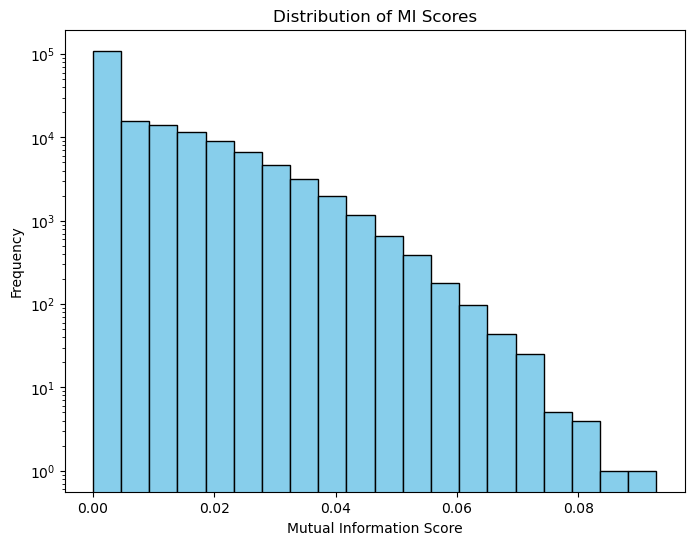

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(mi_scores, bins=20, color='skyblue', edgecolor='black', log=True)
plt.xlabel("Mutual Information Score")
plt.ylabel("Frequency")
plt.title("Distribution of MI Scores")
plt.show()

In [23]:
mi_scores_df[mi_scores_df["MI Score"] > 0.025].shape

(16333, 2)

In [27]:
selected_feat = mi_scores_df[mi_scores_df["MI Score"] > 0.025]["Feature"].tolist()
X_selected = X[selected_feat]

print(f"Selected Features: {selected_feat}")

Selected Features: ['12373_89763', '56273', '367261_81730', '105448', '375979', '521667', '100275_124934', '478496', '88945', '155613', '296775', '607662', '297783', '27902_67770', '382667', '131817', '123127', '63590', '30216', '387895', '22691', '86961', '44258', '387747', '560341', '364115', '48984', '163178', '45045_61201', '375950', '191351', '302485', '329331', '73058_133813', '155072', '147148', '62359', '10314', '179726', '262669', '192206', '138194', '40788', '329559', '104245_137179', '355027', '82486', '322243', '146309', '544815', '328366_165545', '289980_75111', '323074', '261064', '253069', '160512', '135175', '188034', '241198', '345950', '96084_64620', '39355', '341855', '12658', '186386_142428', '478547', '61951', '210162', '100550', '45927', '137302', '63150', '11779', '299829', '186579', '196939', '54816', '339922', '141142', '544128', '345828', '165106', '14323', '231282', '478445', '381547', '63181', '329167', '235439', '44202_36070', '253082', '492843', '44733_608

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [ ]:
# #fitting random forest only on the training data so that there is not influence on the testing performance
# sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# model = RandomForestClassifier()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# print("Classification Report:\n", classification_report(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:\n", cm)

Accuracy: 0.3263157894736842
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.23      0.27        30
           1       0.36      0.59      0.45        41
           2       0.00      0.00      0.00        24

    accuracy                           0.33        95
   macro avg       0.23      0.27      0.24        95
weighted avg       0.26      0.33      0.28        95

Confusion Matrix:
 [[ 7 23  0]
 [ 9 24  8]
 [ 5 19  0]]


In [ ]:
# #see the classification performance
# sel.get_support()

array([False, False, False, ..., False, False, False])

In [ ]:
# selected_feat= X_train.columns[(sel.get_support())]
# len(selected_feat)

14412

In [29]:
l = ["label", "Subject", "Group"]
l.extend(selected_feat)

In [30]:
vcf[l]

,label,Subject,Group,12373_89763,56273,367261_81730,105448,375979,521667,100275_124934,...,211299,355098_174869,9425_152424,138682_109508,261887,88681,249988,11232,78936,415684
0,0,011_S_0002,0.0,0,0,0,0,0,1,0,...,0,0,0,0,2,0,0,2,0,0
3,1,011_S_0002,0.0,0,0,0,0,0,1,0,...,0,0,0,0,2,0,0,2,0,0
5,0,011_S_0008,0.0,0,0,0,0,0,2,0,...,0,0,0,0,1,1,0,2,0,0
8,1,011_S_0008,0.0,0,0,0,0,0,2,0,...,0,0,0,0,1,1,0,2,0,0
9,0,100_S_0015,0.0,0,0,2,0,0,1,0,...,0,0,0,0,2,1,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,1,072_S_4610,1.0,0,1,0,0,0,2,0,...,0,0,0,0,1,1,0,2,0,0
1699,1,072_S_4613,1.0,0,0,0,0,0,1,0,...,0,0,0,0,2,2,0,0,0,1
1700,1,153_S_4621,1.0,0,2,1,1,0,0,0,...,0,1,0,0,2,0,0,1,0,2
1702,2,005_S_4707,2.0,0,1,1,0,0,1,0,...,1,0,0,0,2,1,1,2,0,1


In [31]:
#saving the features with the old dataframe so that the overlap test set can still be used when combining all data
vcf[l].to_pickle("vcf_select.pkl")

In [ ]:
# y_train = pd.DataFrame(y_train)
# y_test = pd.DataFrame(y_test)

In [ ]:
# X_train.to_pickle("X_train_vcf.pkl")
# y_train.to_pickle("y_train_vcf.pkl")

# X_test.to_pickle("X_test_vcf.pkl")
# y_test.to_pickle("y_test_vcf.pkl")

In [ ]:
# X_train = pd.read_pickle("X_train_vcf.pkl")

In [ ]:
# y_train = pd.read_pickle("y_train_vcf.pkl")